# Data Set Information

The data is related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required to assess if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

The classification goal is to predict if the client will subscribe (yes/no) to a term deposit (variable y).

## Attribute Information

### Input variables:

1. **age (numeric)**
2. **job:** type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. **marital:** marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. **education:** (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. **default:** has credit in default? (categorical: 'no','yes','unknown')
6. **housing:** has housing loan? (categorical: 'no','yes','unknown')
7. **loan:** has a personal loan? (categorical: 'no','yes','unknown')

### Related to the last contact of the current campaign:

8. **contact:** contact communication type (categorical: 'cellular','telephone')
9. **month:** last contact month of the year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. **day_of_week:** last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. **duration:** last contact duration, in seconds (numeric). *Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*

### Other attributes:

12. **campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. **pdays:** number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means the client was not previously contacted)
14. **previous:** number of contacts performed before this campaign and for this client (numeric)
15. **poutcome:** outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### Social and economic context attributes:

16. **emp.var.rate:** employment variation rate - quarterly indicator (numeric)
17. **cons.price.idx:** consumer price index - monthly indicator (numeric)
18. **cons.conf.idx:** consumer confidence index - monthly indicator (numeric)
19. **euribor3m:** euribor 3-month rate - daily indicator (numeric)
20. **nr.employed:** number of employees - quarterly indicator (numeric)

### Output variable (desired target):

21. **y:** has the client subscribed to a term deposit? (binary: 'yes','no')


# 1. Importing Libraries and Datasets

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 


from IPython.display import display, HTML
from IPython.display import Image

In [2]:
df=pd.read_csv("bank-additional-full.csv",sep=';')
df=df.drop(['duration'],axis=1)
df1=df.copy()

# 2. Exploratory Data Analysis (EDA)

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(f"Rows: {dataframe.shape[0]}")
    print(f"Columns: {dataframe.shape[1]}")

    print("\n##################### Types #####################")
    print(dataframe.dtypes)

    print("\n##################### Head #####################")
    print(dataframe.head(head))

    print("\n##################### Tail #####################")
    print(dataframe.tail(head))

    print("\n##################### NA #####################")
    print(dataframe.isnull().sum())

    print("\n##################### Quantiles #####################")
    print(dataframe.describe().T)

In [4]:
check_df(df)

##################### Shape #####################
Rows: 41188
Columns: 20

##################### Types #####################
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

##################### Head #####################
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  

In [5]:
##################################################
# Capturing numerical and Categorical variables 
##################################################

# This function analyzes the columns in a dataframe and determines categorical, numerical, and other columns.

def grab_col_names(dataframe, cat_th=8, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() >= car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(df) 

Observations: 41188
Variables: 20
cat_cols: 11
num_cols: 9
cat_but_car: 0
num_but_cat: 0


In [7]:
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

In [8]:
num_cols

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [9]:
#########################################
# Analysis of Categorical Variables
#########################################

# This function performs the analysis and visualization of categorical variables.

def cat_summary(dataframe, col_name, plot=True):

    value_counts = dataframe[col_name].value_counts()
    ratio = 100 * value_counts / len(dataframe)
    
    if plot:
        plt.figure(figsize=(8, 4))
        sns.countplot(y=dataframe[col_name], data=dataframe, order=value_counts.index)
        plt.title(f"{col_name} Distribution")
        plt.xlabel("Count")
        plt.ylabel(col_name)
        plt.xticks(rotation=0)
        
        for i, v in enumerate(value_counts.values):
            plt.text(v + 1, i, f"{v} ({ratio.iloc[i]:.2f}%)", va='center')
        
        plt.show()

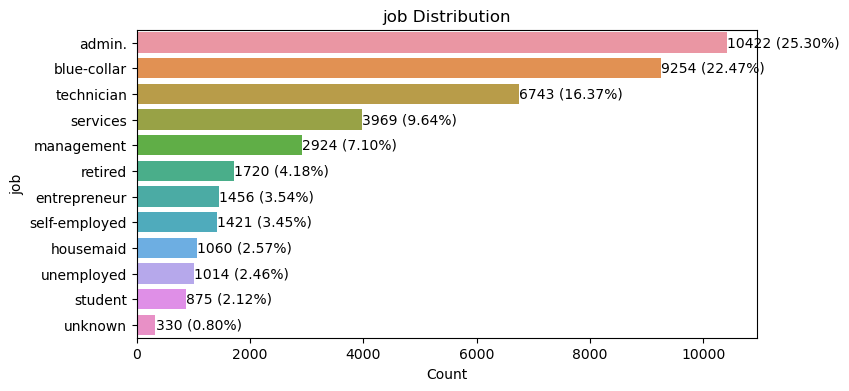

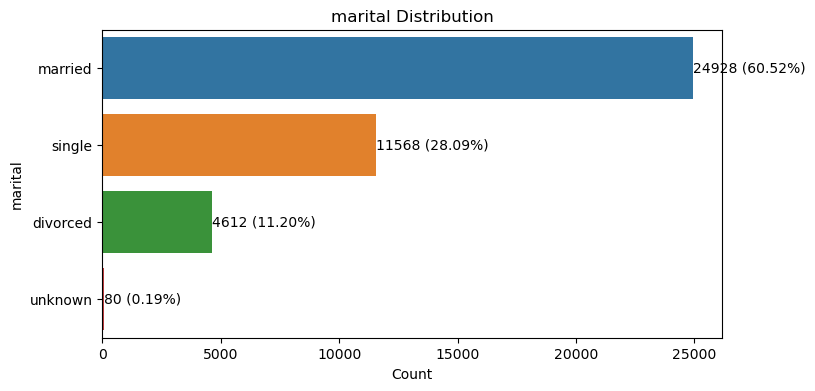

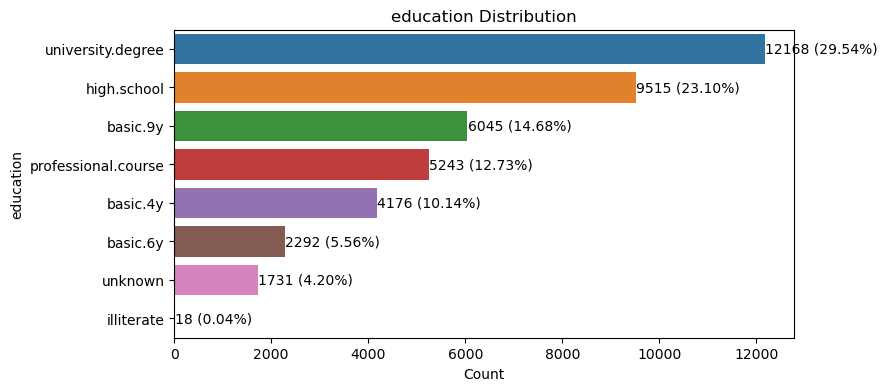

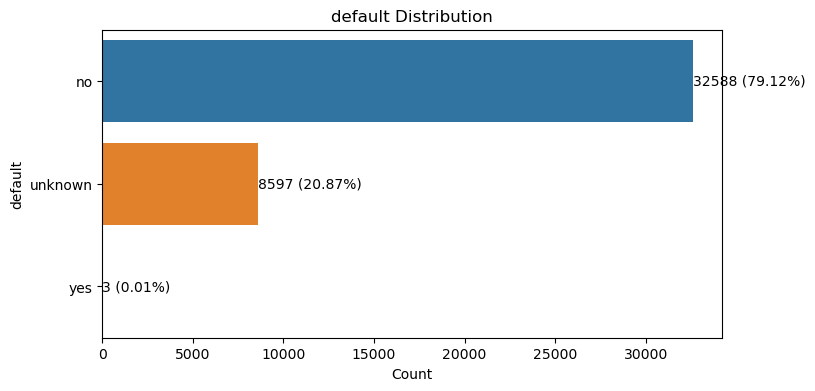

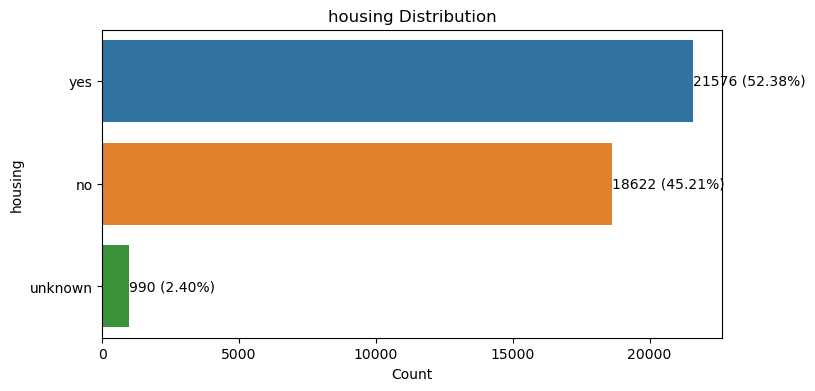

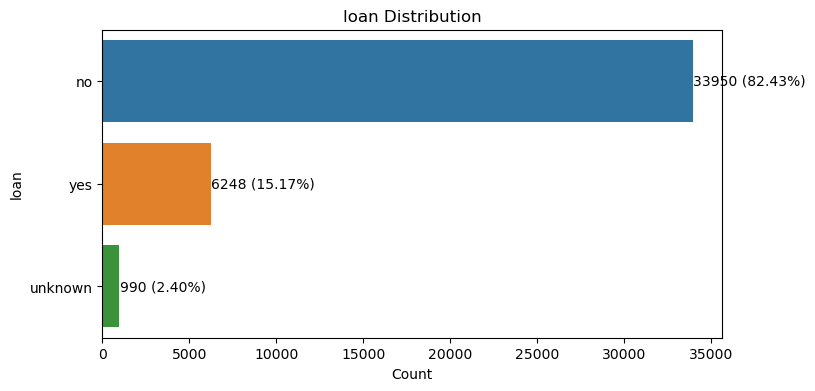

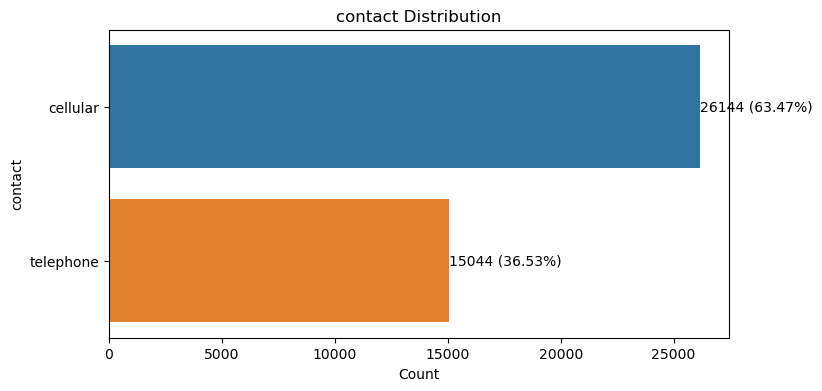

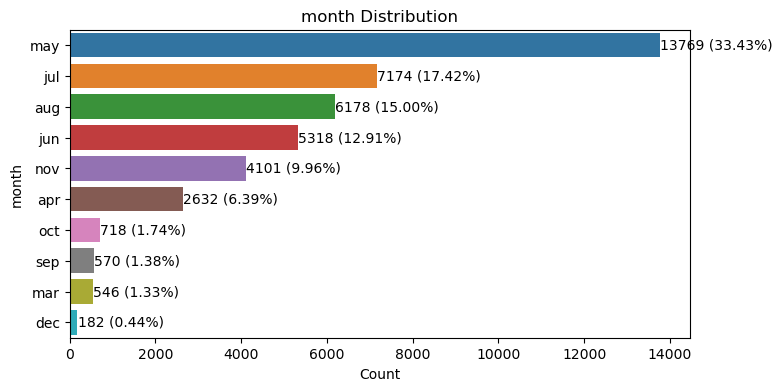

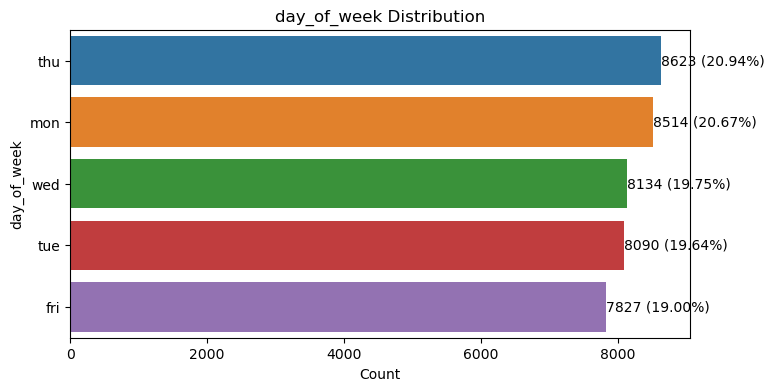

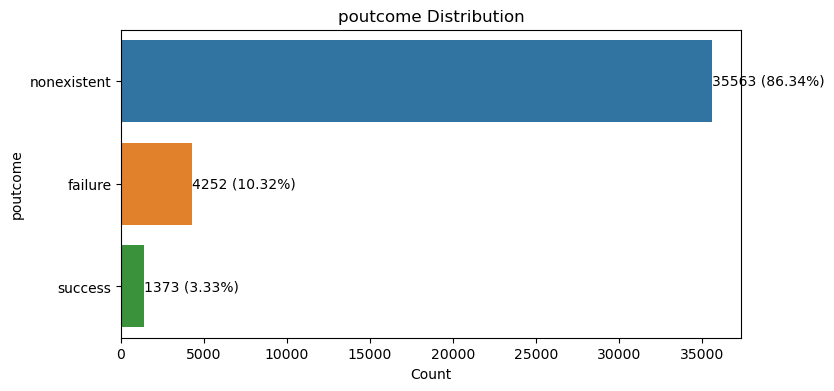

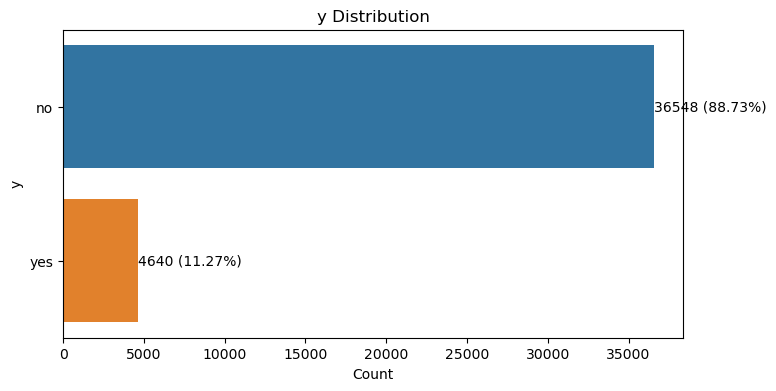

In [10]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [11]:
########################################
# Analysis of Numerical Variables
########################################

# This function performs the analysis of numerical variables and, if desired, visualizes them.

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    summary = dataframe[numerical_col].describe(quantiles)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(18, 4))
        
        # Plot histogram
        dataframe[numerical_col].hist(bins=20, ax=axes[0], color="lightgreen")
        axes[0].set_xlabel(numerical_col)
        axes[0].set_title(numerical_col)
        
        # Displaying summary statistics as text
        summary_text = "\n".join([f'{col}: {value:.3f}' for col, value in summary.items()])
        axes[1].text(0.5, 0.5, summary_text, fontsize=12, va='center', ha='left', linespacing=1.5)
        axes[1].axis('off')  
        
        plt.show()
        print("################################################################")

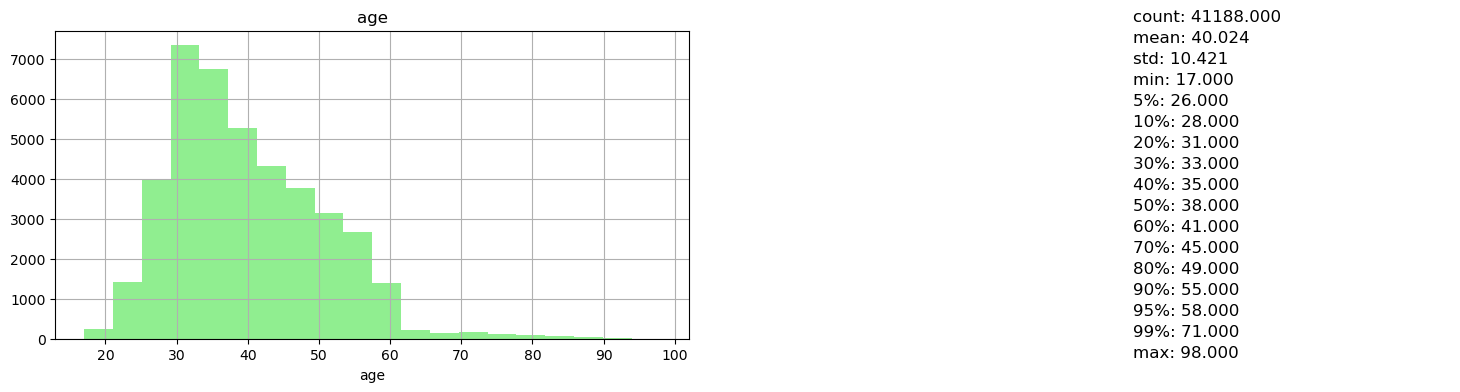

################################################################


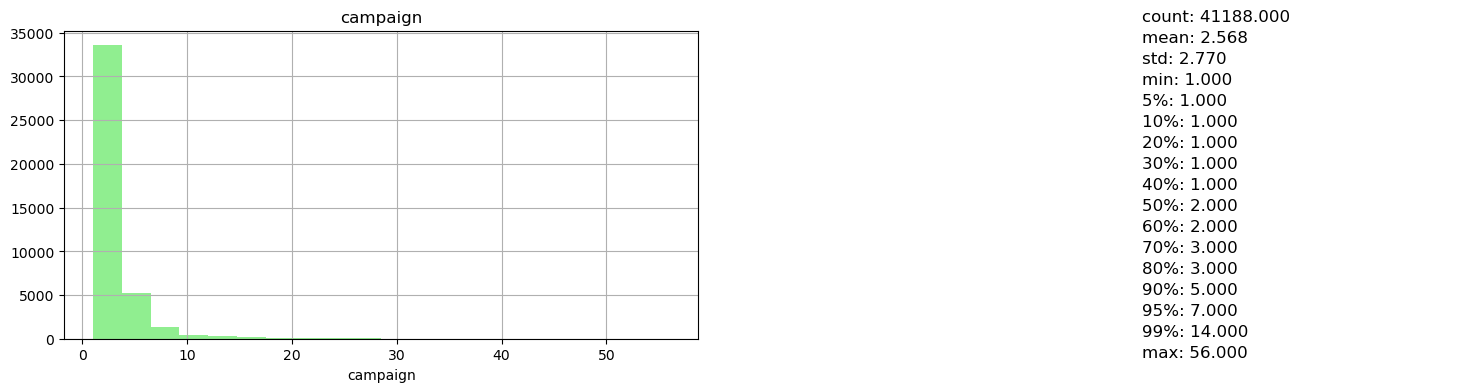

################################################################


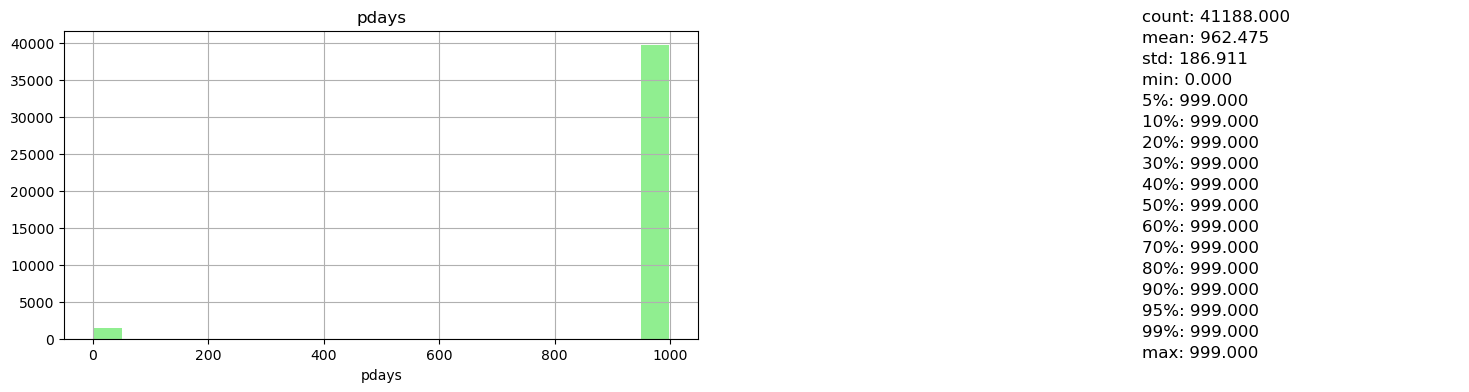

################################################################


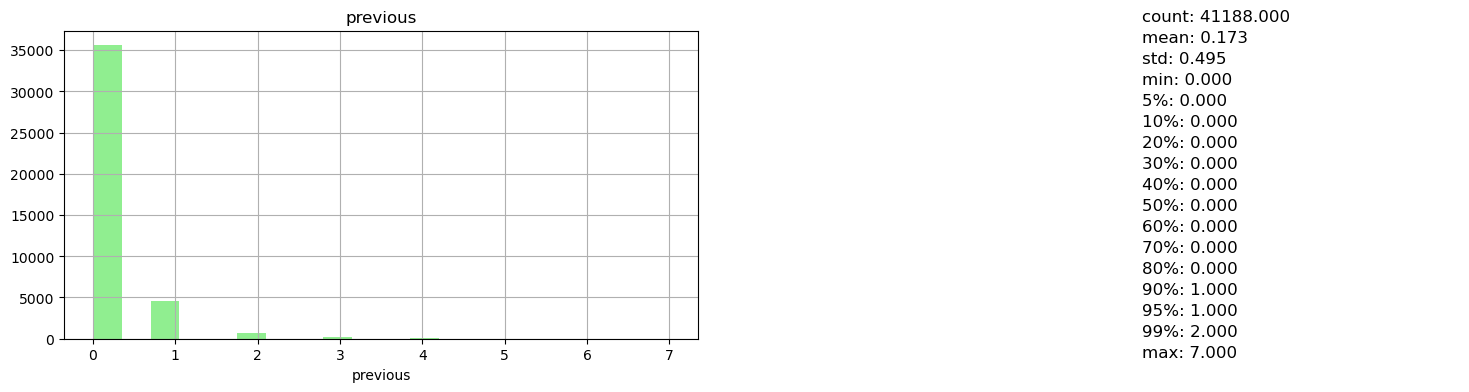

################################################################


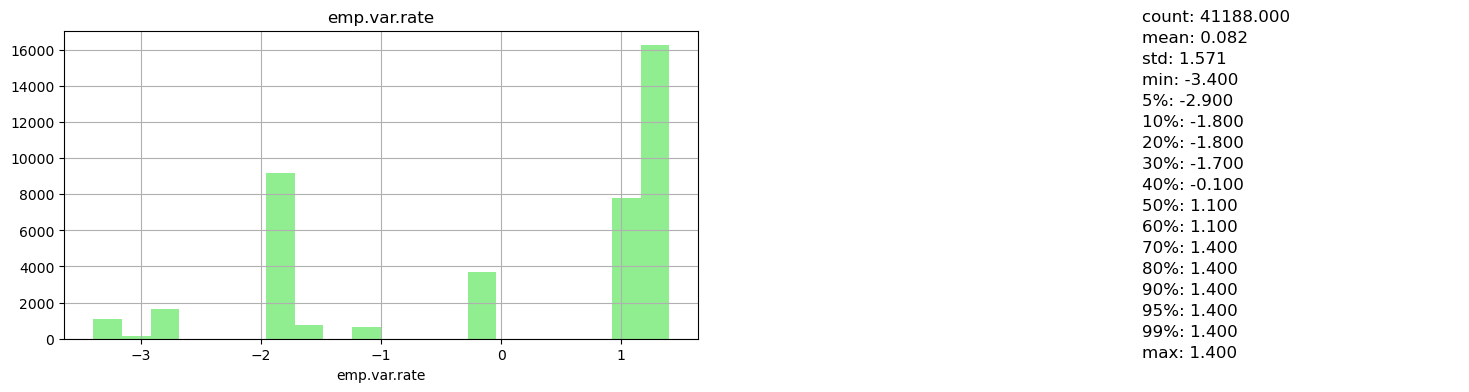

################################################################


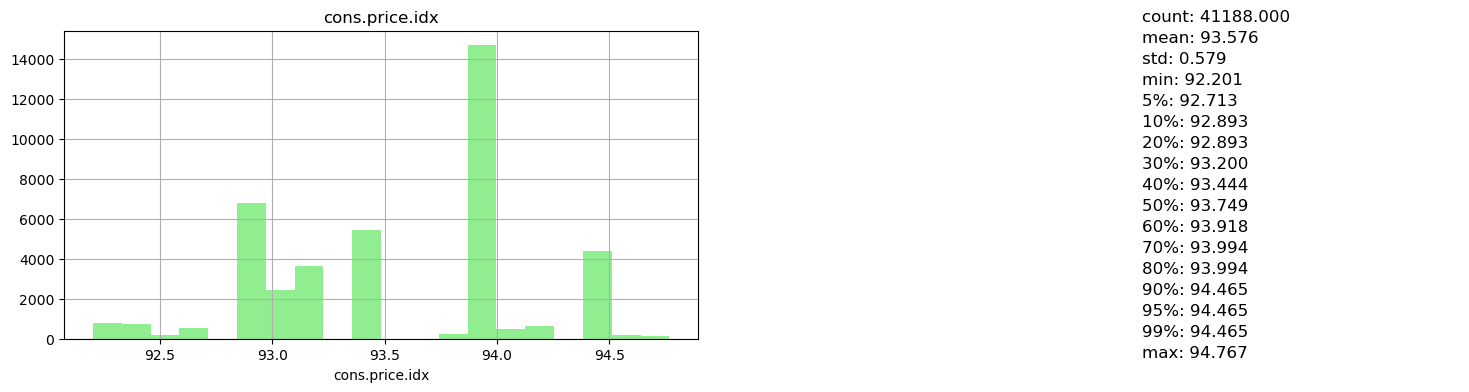

################################################################


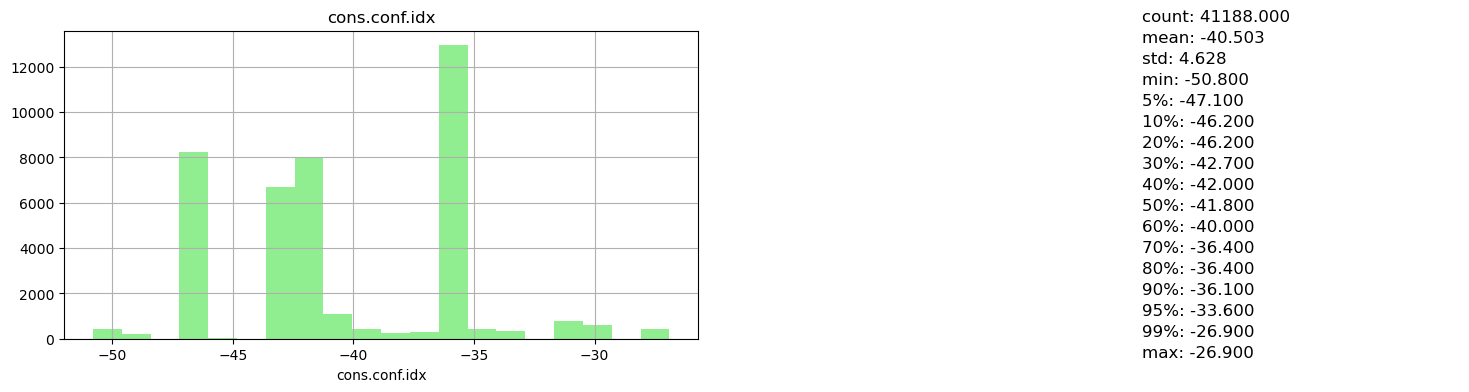

################################################################


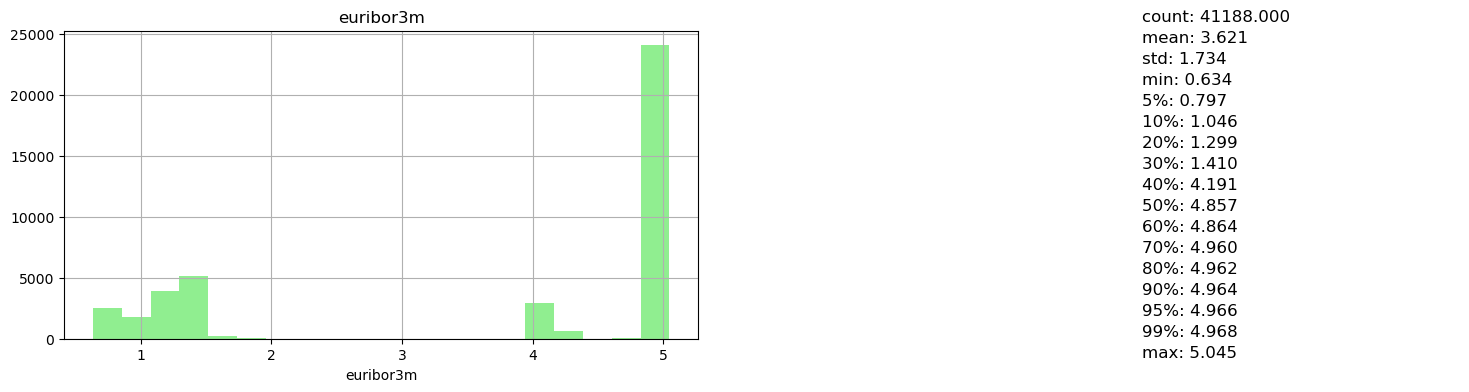

################################################################


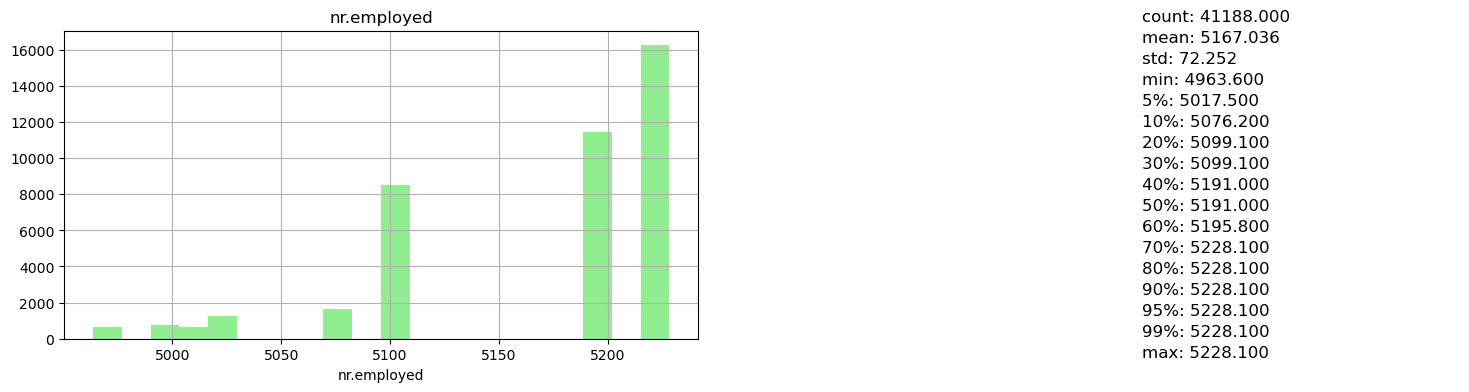

################################################################


In [12]:
for col in num_cols:
    num_summary(df, col, plot=True) 

In [13]:
########################################
#   Target Variable Analysis    
########################################

df["y"] = df["y"].map({"no": 0, "yes": 1})

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
    print("##########################################")

for col in num_cols:
    target_summary_with_num(df, "y", col)

         age
y           
0  39.911185
1  40.913147


##########################################
   campaign
y          
0  2.633085
1  2.051724


##########################################
        pdays
y            
0  984.113878
1  792.035560


##########################################
   previous
y          
0  0.132374
1  0.492672


##########################################
   emp.var.rate
y              
0      0.248875
1     -1.233448


##########################################
   cons.price.idx
y                
0       93.603757
1       93.354386


##########################################
   cons.conf.idx
y               
0     -40.593097
1     -39.789784


##########################################
   euribor3m
y           
0   3.811491
1   2.123135


##########################################
   nr.employed
y             
0  5176.166600
1  5095.115991


##########################################


In [14]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"y_mean": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "y", col)

                 y_mean
job                    
admin.         0.129726
blue-collar    0.068943
entrepreneur   0.085165
housemaid      0.100000
management     0.112175
retired        0.252326
self-employed  0.104856
services       0.081381
student        0.314286
technician     0.108260
unemployed     0.142012
unknown        0.112121


            y_mean
marital           
divorced  0.103209
married   0.101573
single    0.140041
unknown   0.150000


                       y_mean
education                    
basic.4y             0.102490
basic.6y             0.082024
basic.9y             0.078246
high.school          0.108355
illiterate           0.222222
professional.course  0.113485
university.degree    0.137245
unknown              0.145003


          y_mean
default         
no       0.12879
unknown  0.05153
yes      0.00000


           y_mean
housing          
no       0.108796
unknown  0.108081
yes      0.116194


           y_mean
loan             
no       0.113402
unknown  0.

In [15]:
##################################
# Outlier Analysis
##################################

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
  

for col in num_cols:
    print(col, check_outlier(df, col))

age False
campaign True
pdays True
previous True
emp.var.rate False
cons.price.idx False
cons.conf.idx False
euribor3m False
nr.employed False


# 3. Data Cleansing and Transformation

**There are unknown values for many variables in the dataset. Variables with
unknown values include 'education,' 'job,' 'housing,' 'loan,' 'default,' and 'marital'.**

- I didn't just delete the 'unknown' values in the dataset; instead, I used the job and education variables to make sensible assignments based on the real-world scenario where profession is related to education.

- The number of 'unknown' values in the 'marital' variable is very low. Since it is possible that the customer may prefer not to disclose their marital status, I did not take any action for the 'unknown' values in this case.

- The 'default' variable's unknowns are treated as recorded instances of undisclosed information. It is plausible that customers might choose not to reveal this particular information to the banking representative. Therefore, the unknown value in 'default' essentially represents a distinct category.

In [16]:
cross_table = pd.crosstab(df['job'], df['education'], margins=False)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

print(cross_table)

education      basic.4y  basic.6y  basic.9y  high.school  illiterate  professional.course  university.degree  unknown
job                                                                                                                  
admin.               77       151       499         3329           1                  363               5753      249
blue-collar        2318      1426      3623          878           8                  453                 94      454
entrepreneur        137        71       210          234           2                  135                610       57
housemaid           474        77        94          174           1                   59                139       42
management          100        85       166          298           0                   89               2063      123
retired             597        75       145          276           3                  241                285       98
self-employed        93        25       220          118

In [17]:
df['job'][df['age']>65].value_counts()

job
retired          533
housemaid         32
admin.            14
unknown           10
management         9
technician         6
blue-collar        5
entrepreneur       4
unemployed         3
self-employed      2
services           1
Name: count, dtype: int64

In [18]:
df.loc[(df['age']>65) & (df['job']=='unknown'), 'job'] = 'retired'

In [19]:
for job_category in df['job'].unique():
    mode_value = df[df['job'] == job_category]['education'].mode().iloc[0]
    df.loc[(df['job'] == job_category) & (df['education'] == 'unknown'), 'education'] = mode_value


cross_table_after_fill = pd.crosstab(df['job'], df['education'], margins=False)

print(cross_table_after_fill)

education      basic.4y  basic.6y  basic.9y  high.school  illiterate  professional.course  university.degree  unknown
job                                                                                                                  
admin.               77       151       499         3329           1                  363               6002        0
blue-collar        2318      1426      4077          878           8                  453                 94        0
entrepreneur        137        71       210          234           2                  135                667        0
housemaid           516        77        94          174           1                   59                139        0
management          100        85       166          298           0                   89               2186        0
retired             704        75       145          276           3                  241                286        0
self-employed        93        25       220          118

In [20]:
for education_category in df['education'].unique():
    if education_category != 'unknown':
        mode_value = df[df['education'] == education_category]['job'].mode().iloc[0]
        df.loc[(df['education'] == education_category) & (df['job'] == 'unknown'), 'job'] = mode_value


cross_table_after_fill2 = pd.crosstab(df['job'], df['education'], margins=False)


print(cross_table_after_fill2)


education      basic.4y  basic.6y  basic.9y  high.school  illiterate  professional.course  university.degree  unknown
job                                                                                                                  
admin.               77       151       499         3366           1                  363               6046        0
blue-collar        2369      1448      4108          878           8                  453                 94        0
entrepreneur        137        71       210          234           2                  135                667        0
housemaid           516        77        94          174           1                   59                139        0
management          100        85       166          298           0                   89               2186        0
retired             704        75       145          276           3                  241                286        0
self-employed        93        25       220          118

In [21]:
cross_table2 = pd.crosstab(df['job'], df['housing'], margins=False)

print(cross_table2)

housing          no  unknown   yes
job                               
admin.         4671      229  5603
blue-collar    4362      241  4755
entrepreneur    641       36   779
housemaid       491       29   540
management     1363       71  1490
retired         785       44   901
self-employed   641       40   740
services       1818      101  2050
student         381       23   471
technician     2987      147  3621
unemployed      430       27   557
unknown          52        2    69


In [22]:
# Using the precalculated cross-table to fill "unknown" values
def fill_unknown_housing(row):
    if row['housing'] == 'unknown':
        job = row['job']
        total_known_housing = cross_table2.loc[job, ['no', 'yes']].sum()
        
        # If the total known data count is 0, fill as "no"
        if total_known_housing == 0:
            return 'no'
        
        # If the total known data count is not zero, fill using the ratio
        probability_no = cross_table2.loc[job, 'no'] / total_known_housing
        probability_yes = 1 - probability_no  # Probability of being "yes"
        return np.random.choice(['no', 'yes'], p=[probability_no, probability_yes])
    else:
        return row['housing']

    
df['housing'] = df.apply(fill_unknown_housing, axis=1)

print(df['housing'].value_counts())


housing
yes    22091
no     19097
Name: count, dtype: int64


In [23]:
cross_table2_v2 = pd.crosstab(df['job'], df['housing'], margins=False)

print(cross_table2_v2)

housing          no   yes
job                      
admin.         4780  5723
blue-collar    4476  4882
entrepreneur    663   793
housemaid       504   556
management     1399  1525
retired         808   922
self-employed   660   761
services       1862  2107
student         395   480
technician     3054  3701
unemployed      444   570
unknown          52    71


In [24]:
cross_table3 = pd.crosstab(df['job'], df['loan'], margins=False)

print(cross_table3)

loan             no  unknown   yes
job                               
admin.         8548      229  1726
blue-collar    7732      241  1385
entrepreneur   1214       36   206
housemaid       877       29   154
management     2414       71   439
retired        1443       44   243
self-employed  1186       40   195
services       3267      101   601
student         710       23   142
technician     5617      147   991
unemployed      838       27   149
unknown         104        2    17


In [25]:
# Using the precalculated cross-table to fill "unknown" values
def fill_unknown_loan(row):
    if row['loan'] == 'unknown':
        job = row['job']
        total_known_loan = cross_table3.loc[job, ['no', 'yes']].sum()
        
        # If the total known data count is 0, fill as "no"
        if total_known_loan == 0:
            return 'no'
        
        # If the total known data count is not zero, fill using the ratio
        probability_no = cross_table3.loc[job, 'no'] / total_known_loan
        probability_yes = 1 - probability_no  # Probability of being "yes"
        return np.random.choice(['no', 'yes'], p=[probability_no, probability_yes])
    else:
        return row['loan']


df['loan'] = df.apply(fill_unknown_loan, axis=1)

print(df['loan'].value_counts())


loan
no     34770
yes     6418
Name: count, dtype: int64


In [26]:
cross_table3_v2 = pd.crosstab(df['job'], df['loan'], margins=False)

print(cross_table3_v2)

loan             no   yes
job                      
admin.         8731  1772
blue-collar    7938  1420
entrepreneur   1246   210
housemaid       898   162
management     2472   452
retired        1479   251
self-employed  1222   199
services       3351   618
student         730   145
technician     5735  1020
unemployed      862   152
unknown         106    17


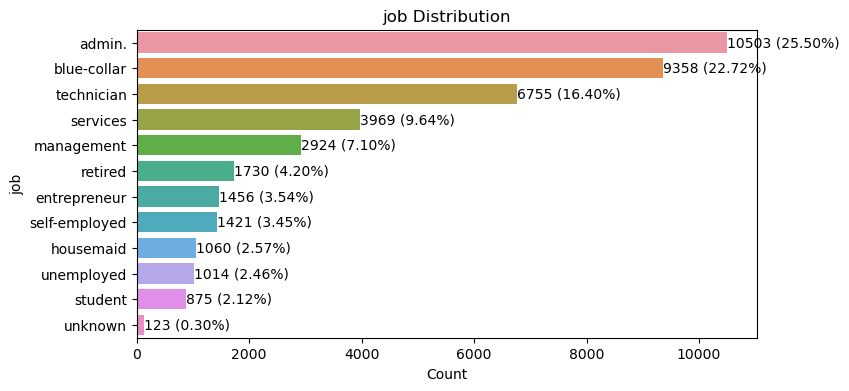

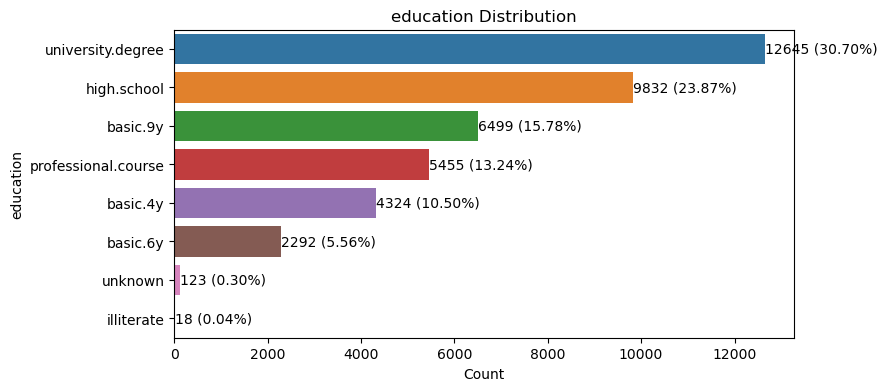

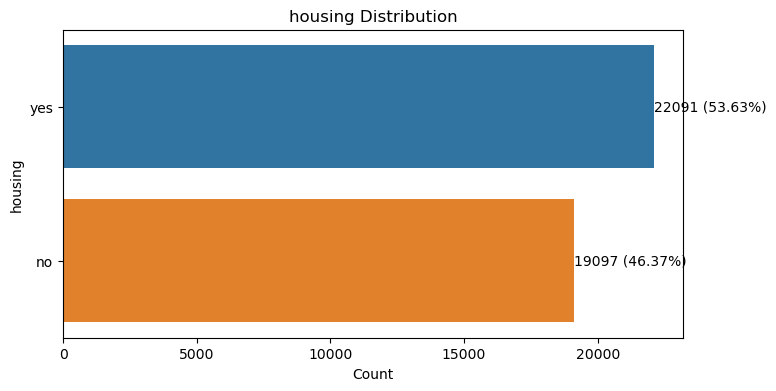

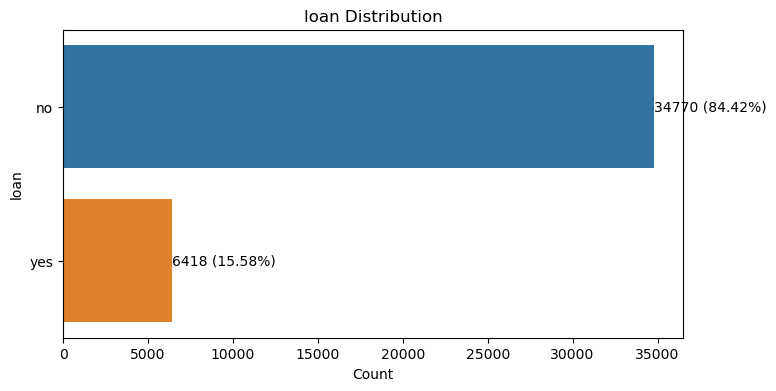

In [27]:
for col in ['job', 'education','housing', 'loan']:
    cat_summary(df, col, plot=True)

In [28]:
df["housing"] = df["housing"].map({"no": 0, "yes": 1})
df["loan"] = df["loan"].map({"no": 0, "yes": 1})

In [29]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,0,0,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,0,0,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,1,0,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,0,0,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,0,1,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [30]:
# Defining the categories with custom labels
bins = [-1, 0, 10, 20, float('inf')]
labels = ['not.contacted', 'recent.contacted', 'moderate.contacted', 'distant.contacted']

# Creating a new categorical column with direct replacement
df['pdays_category'] = pd.cut(np.where(df['pdays'] == 999, -1, df['pdays']), bins=bins, labels=labels, right=False)

print(df['pdays_category'].value_counts())

pdays_category
not.contacted         39673
recent.contacted       1259
moderate.contacted      247
distant.contacted         9
Name: count, dtype: int64


In [31]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_category
0,56,housemaid,married,basic.4y,no,0,0,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,not.contacted
1,57,services,married,high.school,unknown,0,0,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,not.contacted
2,37,services,married,high.school,no,1,0,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,not.contacted
3,40,admin.,married,basic.6y,no,0,0,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,not.contacted
4,56,services,married,high.school,no,0,1,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,not.contacted


In [32]:
df.drop('pdays', axis=1, inplace=True)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_category
0,56,housemaid,married,basic.4y,no,0,0,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,not.contacted
1,57,services,married,high.school,unknown,0,0,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,not.contacted
2,37,services,married,high.school,no,1,0,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,not.contacted
3,40,admin.,married,basic.6y,no,0,0,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,not.contacted
4,56,services,married,high.school,no,0,1,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,not.contacted
